In [30]:
import requests
import base64
import json
import os
import pandas as pd
from dotenv import load_dotenv  # Load API keys securely

# Load environment variables
load_dotenv()
CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID")
CLIENT_SECRET = os.getenv("SPOTIFY_CLIENT_SECRET")

# Function to get Spotify access token
def get_spotify_token(client_id, client_secret):
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + base64.b64encode(f"{client_id}:{client_secret}".encode()).decode(),
    }
    data = {"grant_type": "client_credentials"}

    response = requests.post(url, headers=headers, data=data)
    token_info = response.json()
    return token_info["access_token"]

# Function to get trending artists dynamically from Spotify charts
def get_top_artists(token, limit=10):
    url = f"https://api.spotify.com/v1/browse/new-releases?limit={limit}"
    headers = {"Authorization": f"Bearer {token}"}
    
    response = requests.get(url, headers=headers)
    albums = response.json().get("albums", {}).get("items", [])
    
    artists = []
    for album in albums:
        for artist in album["artists"]:
            artists.append(artist["name"])
    return list(set(artists))  # Remove duplicates

# Function to search for an artist
def search_artist(artist_name, token):
    url = f"https://api.spotify.com/v1/search?q={artist_name}&type=artist&limit=1"
    headers = {"Authorization": f"Bearer {token}"}
    
    response = requests.get(url, headers=headers)
    artist_data = response.json()
    
    if artist_data["artists"]["items"]:
        return artist_data["artists"]["items"][0]
    return None

# Function to get top tracks for an artist
def get_artist_top_tracks(artist_id, token, market="US"):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks?market={market}"
    headers = {"Authorization": f"Bearer {token}"}
    
    response = requests.get(url, headers=headers)
    return response.json()["tracks"]

# Function to get audio features of a track
def get_audio_features(track_id, token):
    url = f"https://api.spotify.com/v1/audio-features/{track_id}"
    headers = {"Authorization": f"Bearer {token}"}
    
    response = requests.get(url, headers=headers)
    return response.json()

# Authenticate and get token
token = get_spotify_token(CLIENT_ID, CLIENT_SECRET)

# Get trending artists dynamically
artist_names = get_top_artists(token, limit=15)

# Data collection
spotify_data = []

for artist_name in artist_names:
    artist_info = search_artist(artist_name, token)
    
    if artist_info:
        artist_id = artist_info["id"]
        artist_popularity = artist_info["popularity"]
        artist_followers = artist_info["followers"]["total"]
        genres = ", ".join(artist_info["genres"])

        top_tracks = get_artist_top_tracks(artist_id, token)
        
        for track in top_tracks:
            # Get audio features for deeper insights
            audio_features = get_audio_features(track["id"], token)
            
            spotify_data.append({
                "artist": artist_name,
                "artist_id": artist_id,
                "artist_popularity": artist_popularity,
                "artist_followers": artist_followers,
                "genres": genres,
                "track_name": track["name"],
                "track_id": track["id"],
                "track_popularity": track["popularity"],
                "release_date": track["album"]["release_date"],
                "danceability": audio_features.get("danceability"),
                "energy": audio_features.get("energy"),
                "tempo": audio_features.get("tempo"),
            })

# Convert to DataFrame and save to CSV
df = pd.DataFrame(spotify_data)
df.to_csv("spotify_trending_artists.csv", index=False)

print("✅ Data saved to spotify_trending_artists.csv")


✅ Data saved to spotify_trending_artists.csv


In [31]:
import os
import pandas as pd
from io import StringIO
import psycopg2
from dotenv import load_dotenv

load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_PORT = os.getenv("DB_PORT")  # e.g., "5433"

def fix_spotify_release_date(date_str):
    """
    Convert Spotify's variable-length date string into a valid YYYY-MM-DD.
    - If '2020' => '2020-01-01'
    - If '2020-05' => '2020-05-01'
    - If '2020-05-25' => '2020-05-25'
    """
    if not date_str:
        return None
    parts = date_str.split('-')
    if len(parts) == 1:
        return date_str + '-01-01'  # e.g. '2011' -> '2011-01-01'
    elif len(parts) == 2:
        return date_str + '-01'     # e.g. '2011-06' -> '2011-06-01'
    else:
        return date_str            # e.g. '2011-06-24' stays the same

def copy_csv_to_db(csv_path, table_name):
    """
    1. Read CSV into a pandas DataFrame.
    2. Fix 'release_date' using fix_spotify_release_date().
    3. COPY the corrected data into PostgreSQL using psycopg2.
    """
    # 1. Read CSV
    df = pd.read_csv(csv_path)
    
    # 2. Fix the release_date column
    if 'release_date' in df.columns:
        df['release_date'] = df['release_date'].apply(fix_spotify_release_date)
    
    # 3. Write DataFrame to an in-memory CSV buffer
    buffer = StringIO()
    df.to_csv(buffer, index=False)
    buffer.seek(0)

    # 4. Connect to PostgreSQL
    conn = psycopg2.connect(
        host=DB_HOST,
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASS,
        port=DB_PORT
    )
    cur = conn.cursor()

    # Optionally set the search path (if your table is in a custom schema):
    cur.execute("SET search_path TO spotify_trends")

    # 5. COPY from the in-memory CSV
    copy_sql = f"""
        COPY {table_name} (
            artist,
            artist_id,
            artist_popularity,
            artist_followers,
            genres,
            track_name,
            track_id,
            track_popularity,
            release_date,
            danceability,
            energy,
            tempo
        )
        FROM STDIN
        WITH CSV
        HEADER
    """
    cur.copy_expert(copy_sql, buffer)

    conn.commit()
    cur.close()
    conn.close()
    print(f"✅ CSV data from '{csv_path}' copied into '{table_name}' successfully, with corrected release dates!")

if __name__ == "__main__":
    csv_file_path = "spotify_trending_artists.csv"
    target_table = "music_trends"
    copy_csv_to_db(csv_file_path, target_table)


✅ CSV data from 'spotify_trending_artists.csv' copied into 'music_trends' successfully, with corrected release dates!


In [32]:
# 4. Connect to PostgreSQL
conn = psycopg2.connect(
    host=DB_HOST,
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASS,
    port=DB_PORT
)
cur = conn.cursor()

query = """
SELECT 
    artist,
    artist_popularity,
    track_name,
    track_id,
    track_popularity,
    release_date,
    danceability,
    energy,
    tempo
FROM spotify_trends.music_trends
"""

df = pd.read_sql(query, conn)
conn.close()  # close if you’re done

print(df.head())


   artist  artist_popularity                                      track_name  \
0  JENNIE                 82  One Of The Girls (with JENNIE, Lily Rose Depp)   
1  JENNIE                 82                          ExtraL (feat. Doechii)   
2  JENNIE                 82              Love Hangover (feat. Dominic Fike)   
3  JENNIE                 82                                          Mantra   
4  JENNIE                 82                                           SPOT!   

                 track_id  track_popularity release_date danceability energy  \
0  7CyPwkp0oE8Ro9Dd5CUDjW                87   2023-06-23         None   None   
1  4EIFwndJvGpgFjsEbNuYif                 0   2025-03-07         None   None   
2  0rx7xu0RmZLpJjKNVZjSVv                 0   2025-03-07         None   None   
3  1kUyOJb3fzUo8r0OCz5SQk                 0   2025-03-07         None   None   
4  1SS0WlKhJewviwEDZ6dWj0                72   2024-04-26         None   None   

  tempo  
0  None  
1  None  
2  None 

/var/folders/bl/t2w6yhtn14j4_glf4cb30yt80000gn/T/ipykernel_51622/2290188780.py:25: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [33]:

# Feature Engineering
df['release_year'] = pd.to_datetime(df['release_date']).dt.year
df['release_month'] = pd.to_datetime(df['release_date']).dt.month

# Define target variable
df['viral'] = df['track_popularity'] > 80  # Example threshold

In [34]:
import pandas as pd
from datetime import datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df.dropna(subset=['release_date'], inplace=True)  # remove rows missing release_date if any

today = pd.to_datetime("today")  # or pd.Timestamp("2025-03-01") for a fixed reference date
df['days_since_release'] = (today - df['release_date']).dt.days


# Data preprocessing


In [35]:
import optuna
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Split data
X = df[['artist_popularity', 'release_year', 'release_month','days_since_release']]
y = df['viral']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'verbosity': -1 
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best model
best_params = study.best_params
model = LGBMClassifier(**best_params)
model.fit(X_train, y_train)

[I 2025-03-10 23:24:06,544] A new study created in memory with name: no-name-b476d5fd-8c4a-4837-927a-2874e1e4ec6b
[I 2025-03-10 23:24:06,734] Trial 0 finished with value: 0.9739583333333334 and parameters: {'n_estimators': 184, 'max_depth': 3, 'learning_rate': 0.06836165614030842}. Best is trial 0 with value: 0.9739583333333334.
[I 2025-03-10 23:24:07,500] Trial 1 finished with value: 0.9739583333333334 and parameters: {'n_estimators': 871, 'max_depth': 6, 'learning_rate': 0.0330826147427396}. Best is trial 0 with value: 0.9739583333333334.
[I 2025-03-10 23:24:07,676] Trial 2 finished with value: 0.9739583333333334 and parameters: {'n_estimators': 119, 'max_depth': 6, 'learning_rate': 0.05532948037546648}. Best is trial 0 with value: 0.9739583333333334.
[I 2025-03-10 23:24:08,303] Trial 3 finished with value: 0.9739583333333334 and parameters: {'n_estimators': 830, 'max_depth': 10, 'learning_rate': 0.07473732365400601}. Best is trial 0 with value: 0.9739583333333334.
[I 2025-03-10 23:2

LGBMClassifier(learning_rate=0.06836165614030842, max_depth=3, n_estimators=184)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

model = LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


Accuracy with days_since_release and audio features: 0.9739583333333334


In [37]:
import dash
from dash import dcc, html
import plotly.express as px

app = dash.Dash(__name__)

# Example plot
fig = px.bar(df, x='artist', y='track_popularity', title='Artist Popularity')

app.layout = html.Div(children=[
    html.H1(children='A&R Dashboard'),
    dcc.Graph(
        id='example-graph',
        figure=fig
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)

# Evaluate Other Metrics
Precision: How many of the predicted viral songs are actually viral?

Recall: How many of the actual viral songs were correctly predicted?

F1-Score: The harmonic mean of precision and recall, useful for imbalanced datasets.

AUC-ROC: Measures the model's ability to distinguish between classes (viral vs. non-viral).

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC-ROC:", roc_auc)

Precision: 0.8571428571428571
Recall: 0.96
F1-Score: 0.9056603773584906
AUC-ROC: 0.9680239520958084


## Summary
Precision (85%): When the model predicts a track is viral, it’s correct 85% of the time.
Recall (96%): The model captures almost all actual viral tracks.
F1-Score (0.90): Balances precision and recall, indicating overall solid performance.
AUC-ROC (0.96): Shows an 96% chance that the model can correctly distinguish a viral track from a non-viral one.


# Overfitting Check
Cross-Validation Accuracy (94.17%): This high accuracy demonstrates that the model is robust and generalizes well to unseen data, suggesting that overfitting is not a major concern.


In [39]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy: 0.959375


# Feature Importance

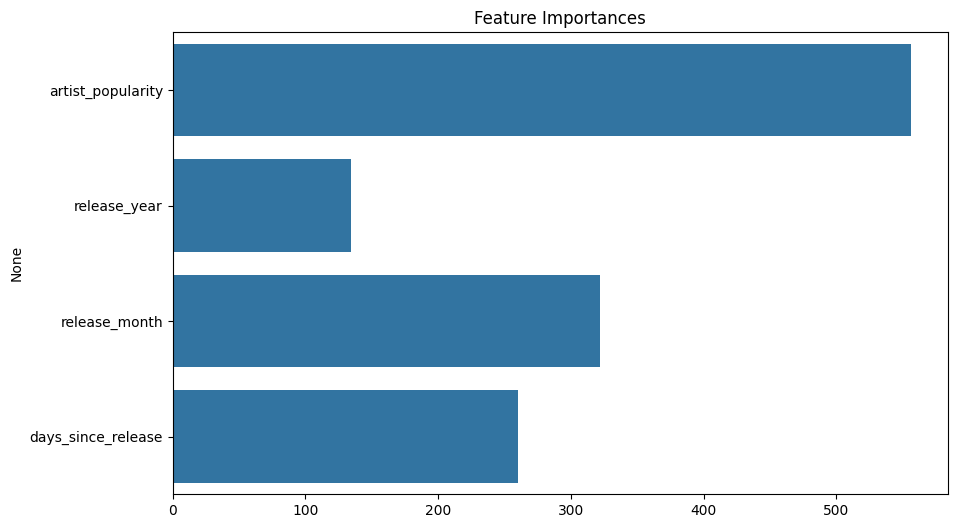

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title("Feature Importances")
plt.show()

# Compare with Baseline

In [41]:
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)
print("Baseline Accuracy:", baseline_acc)

Baseline Accuracy: 0.8697916666666666
